# Исследование объявлений о продаже квартир
В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Наша задача — установить параметры для определения рыночной стоимости объектов недвижимости. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных: первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

**Описание данных**

* 'children' — количество детей в семье
* 'days_employed' — общий трудовой стаж в днях
* 'dob_years' — возраст клиента в годах
* 'education' — уровень образования клиента
* 'education_id' — идентификатор уровня образования
* 'family_status' — семейное положение
* 'family_status_id' — идентификатор семейного положения
* 'gender' — пол клиента
* 'income_type' — тип занятости
* 'debt' — имел ли задолженность по возврату кредитов
* 'total_income' — ежемесячный доход
* 'purpose' — цель получения кредита

### Откройте файл с данными и изучите общую информацию. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t') #прочитаем файл с данными и сохраним в переменной data
data.info() # выведем на экран общую информацию о таблице 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Из информации о таблице видим, что в данных встречаются пропуски, а так же некорректный тип данных.

In [3]:
pd.options.display.max_columns=22 # настроим pandas так, чтобы все столбцы отображались 
#(изучив информацию о датафрейме, мы видим, что в нем 22 столбца)
data.head() # выведем на экран первые 5 строк таблицы

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


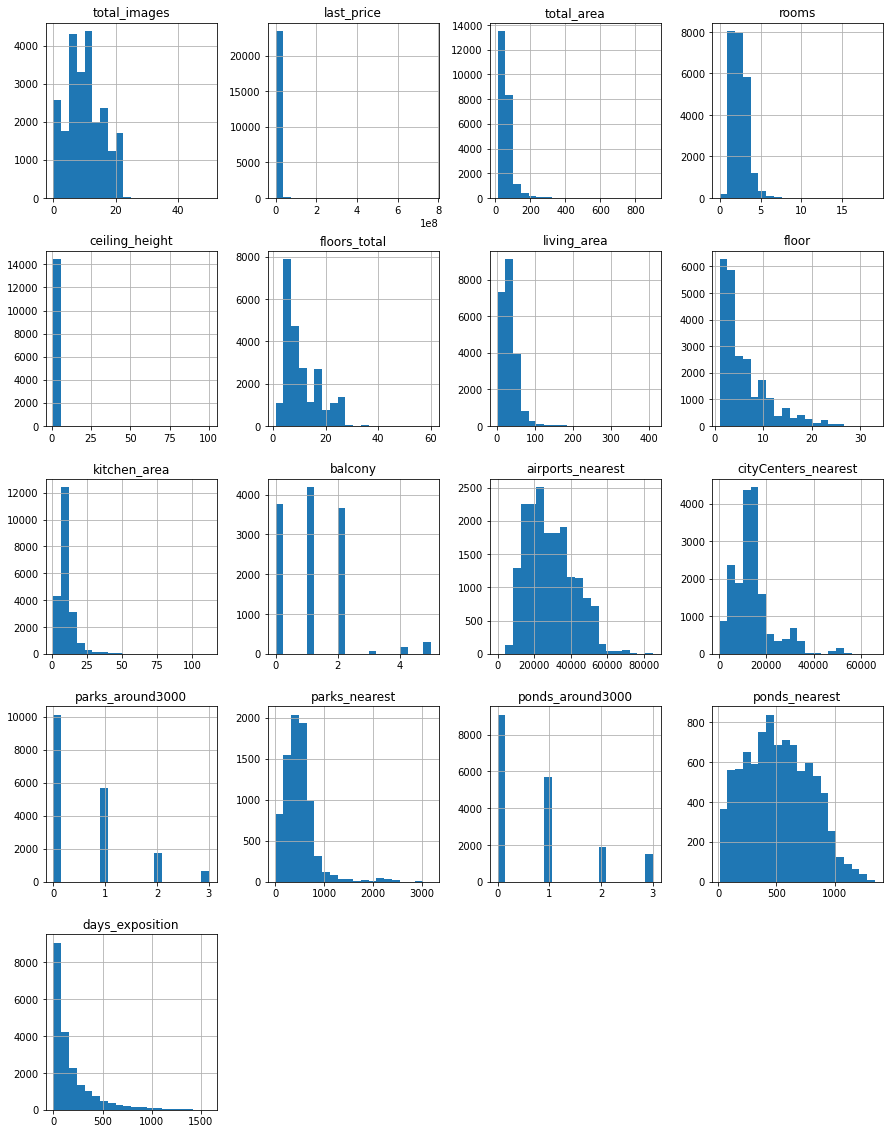

In [4]:
data.hist(bins=20, figsize=(15,20)); # построим гистограмму для всех столбцов таблицы

### Предобработка данных

In [5]:
# посчитаем пропущенные значения в столбцах
data.isna().sum()


total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

Для начала попробуем избавится от пропусков данных.
Заменим пропуски в столбце is_apartment на False, т.к., скорей всего если бы это были апартаменты, то это было бы указано да и само понятие апартаменты на нашем рынке недвижимости появилось не так давно, а пропусков почти 90%, так же поменяем тип данных, чтобы он стал буллевным.

In [6]:
# заменим пропуски в столбце is_apartment на False и  поменяем тип данных
data['is_apartment'] = data['is_apartment'].fillna(False).astype(bool)


In [7]:
# пропуски в столбце balcony, скорей всего, из-за того что в квартире нет балкона, заменим пропуски на 0
#и изменим тип данных на int, т.к. количество балконов целое число
data['balcony'] = data['balcony'].fillna(0).astype(int)

Пропусков в 'locality_name' всего 49, изучим их поподробнее.

In [8]:
# переименуем все пропуски
data['locality_name'] = data['locality_name'].fillna('нет') 
data1 = data.query('locality_name=="нет"') #сделаем срез данных только с незаполненными строками
data1.head(49)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
1097,3,8600000.0,81.70,2016-04-15T00:00:00,3,3.55,5.0,50.80,2,False,False,False,8.80,0,нет,23478.0,4258.0,0.0,NaN,0.0,NaN,147.0
2033,6,5398000.0,80.00,2017-05-30T00:00:00,3,NaN,4.0,42.60,2,False,False,False,18.60,0,нет,NaN,NaN,NaN,NaN,NaN,NaN,34.0
2603,20,3351765.0,42.70,2015-09-20T00:00:00,1,NaN,24.0,15.60,3,False,False,False,10.70,0,нет,22041.0,17369.0,0.0,NaN,1.0,374.0,276.0
2632,2,5130593.0,62.40,2015-10-11T00:00:00,2,NaN,24.0,33.10,21,False,False,False,8.20,0,нет,22041.0,17369.0,0.0,NaN,1.0,374.0,256.0
3574,10,4200000.0,46.50,2016-05-28T00:00:00,2,NaN,5.0,30.80,5,False,False,False,6.50,0,нет,27419.0,8127.0,0.0,NaN,1.0,603.0,45.0
4151,17,17600000.0,89.50,2014-12-09T00:00:00,2,3.00,8.0,39.62,7,False,False,False,13.38,0,нет,25054.0,3902.0,1.0,485.0,3.0,722.0,869.0
4189,7,9200000.0,80.00,2015-12-10T00:00:00,3,4.00,4.0,52.30,3,False,False,False,10.40,0,нет,21774.0,3039.0,1.0,690.0,1.0,953.0,223.0
4670,1,5500000.0,83.00,2015-08-14T00:00:00,3,NaN,7.0,NaN,6,False,False,False,NaN,0,нет,26534.0,5382.0,1.0,446.0,1.0,376.0,350.0
5343,19,13540000.0,85.50,2016-01-20T00:00:00,3,NaN,7.0,59.10,5,False,False,False,8.30,4,нет,10556.0,9538.0,1.0,67.0,0.0,NaN,303.0
5707,7,3700000.0,30.00,2016-04-29T00:00:00,1,NaN,24.0,20.00,23,False,False,False,NaN,0,нет,21460.0,16788.0,0.0,NaN,1.0,170.0,49.0


Изучив данные столбца 'cityCenters_nearest' датафрейма data1, можно заметить, что разброс по расстоянию до центра города достаточно большой (от 1 до 41 км), поэтому нельзя стопроцентно утверждать, что все данные объкты находятся в Санкт-Петербурге. Учитывая, что пропущенно у нас всего 49 строк, оставим данный столбец без изменений.

In [9]:
# изучем данные о площади кухни, чтобы понять как правильнее заполнить пропуски
data['kitchen_area'].describe()

count    21421.000000
mean        10.569807
std          5.905438
min          1.300000
25%          7.000000
50%          9.100000
75%         12.000000
max        112.000000
Name: kitchen_area, dtype: float64

Из информации о столбце видим, что стандартное отклонение достаточно большое (около 56% от среднего), это говорит о том, что разброс значений достаточно высок и некорректно будет заполнить пропуски средним значением. Пока оставим данный столбец с пропусками, в дальнейшем, посмотрим как повлияют пропущенные значения.

In [10]:
# теперь изучем данные о высоте потолков и проанализируем возможность замены на среднее значение, 
# почти 40% данных в данном столбце отсутствует 
data['ceiling_height'].describe()

count    14504.000000
mean         2.771499
std          1.261056
min          1.000000
25%          2.520000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64

Сразу бросается в глаза аномальные значения максимальной (100 метров) и минимальной велечины (1 метр). Необходимо избавится от данной аномалии,т.к. они влияют на расчеты. 

In [11]:
#посмотрим какие значения есть в данных с высотой потолка 
sorted_data_ceiling = data['ceiling_height'].sort_values()
sorted_data_ceiling.unique()

array([  1.  ,   1.2 ,   1.75,   2.  ,   2.2 ,   2.25,   2.3 ,   2.34,
         2.4 ,   2.45,   2.46,   2.47,   2.48,   2.49,   2.5 ,   2.51,
         2.52,   2.53,   2.54,   2.55,   2.56,   2.57,   2.58,   2.59,
         2.6 ,   2.61,   2.62,   2.63,   2.64,   2.65,   2.66,   2.67,
         2.68,   2.69,   2.7 ,   2.71,   2.72,   2.73,   2.74,   2.75,
         2.76,   2.77,   2.78,   2.79,   2.8 ,   2.81,   2.82,   2.83,
         2.84,   2.85,   2.86,   2.87,   2.88,   2.89,   2.9 ,   2.91,
         2.92,   2.93,   2.94,   2.95,   2.96,   2.97,   2.98,   2.99,
         3.  ,   3.01,   3.02,   3.03,   3.04,   3.05,   3.06,   3.07,
         3.08,   3.09,   3.1 ,   3.11,   3.12,   3.13,   3.14,   3.15,
         3.16,   3.17,   3.18,   3.2 ,   3.21,   3.22,   3.23,   3.24,
         3.25,   3.26,   3.27,   3.28,   3.29,   3.3 ,   3.31,   3.32,
         3.33,   3.34,   3.35,   3.36,   3.37,   3.38,   3.39,   3.4 ,
         3.42,   3.43,   3.44,   3.45,   3.46,   3.47,   3.48,   3.49,
      

Видим, что кроме 1 и 100 метров, есть еще 20, 22.6, 24, 25, 26, 27, 27.5, 32 метров. Скорей всего данные значения получились из-за ошибочно поставленной запятой, т.е. не 20, а 2.0, не 22.6 - 2.6 и т.п. Прежде, чем удалять аномальное большие и маленькие значения, приведем данные значения в порядок.

In [12]:
#создадим список с неправильными значениями
wrong_ctiling_height = [20, 22.6, 24, 25, 26, 27, 27.5, 32]
#создадим список с верными значениями
correct_ctiling_height = [2.0, 2.6, 2.4, 2.5, 2.6, 2.7, 2.75, 3.2]
data['ceiling_height'] = data['ceiling_height'].replace(wrong_ctiling_height, correct_ctiling_height)

In [13]:
# посмотрим много ли строк с высотой меньше 1,9 и 2 метров, чтобы принять решение ниже какого значения данные можно удалить
sorted_data1 = data.query('ceiling_height<=1.9')
sorted_data1

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
5712,5,1500000.0,42.8,2017-08-14T00:00:00,2,1.20,2.0,27.5,1,False,False,False,5.20,0,городской посёлок Мга,NaN,NaN,NaN,NaN,NaN,NaN,248.0
16934,5,4100000.0,40.0,2017-10-17T00:00:00,1,1.75,37.0,17.4,5,False,False,False,8.34,0,Санкт-Петербург,18732.0,20444.0,0.0,NaN,3.0,80.0,71.0
22590,16,6000000.0,55.0,2018-10-31T00:00:00,2,1.00,12.0,32.4,7,False,False,False,10.00,0,Санкт-Петербург,33053.0,14217.0,2.0,293.0,2.0,289.0,13.0


In [14]:
sorted_data2 = data.query('ceiling_height<=2')
sorted_data2

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
552,11,2999000.0,33.50,2017-03-30T00:00:00,1,2.00,15.0,17.5,6,False,False,False,6.50,0,Санкт-Петербург,33972.0,11746.0,1.0,520.0,1.0,949.0,270.0
2572,4,2400000.0,62.00,2018-12-27T00:00:00,3,2.00,5.0,40.0,4,False,False,False,6.00,1,Луга,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4212,1,2120000.0,35.43,2017-12-18T00:00:00,1,2.00,18.0,16.6,9,False,False,False,8.80,2,Тосно,NaN,NaN,NaN,NaN,NaN,NaN,36.0
5712,5,1500000.0,42.80,2017-08-14T00:00:00,2,1.20,2.0,27.5,1,False,False,False,5.20,0,городской посёлок Мга,NaN,NaN,NaN,NaN,NaN,NaN,248.0
5850,9,1650000.0,35.50,2018-05-29T00:00:00,1,2.00,5.0,NaN,5,False,False,False,NaN,0,Луга,NaN,NaN,NaN,NaN,NaN,NaN,100.0
11352,4,3300000.0,36.00,2017-06-18T00:00:00,1,2.00,17.0,15.2,12,False,False,False,10.10,0,посёлок Металлострой,25268.0,26980.0,0.0,NaN,0.0,NaN,53.0
16446,6,12300000.0,88.30,2019-03-12T00:00:00,3,2.00,5.0,63.9,2,False,False,False,12.00,0,Санкт-Петербург,38415.0,7675.0,1.0,568.0,1.0,154.0,NaN
16884,0,1500000.0,33.00,2018-10-03T00:00:00,1,2.00,5.0,20.0,5,False,False,False,6.00,0,Выборг,NaN,NaN,NaN,NaN,NaN,NaN,6.0
16934,5,4100000.0,40.00,2017-10-17T00:00:00,1,1.75,37.0,17.4,5,False,False,False,8.34,0,Санкт-Петербург,18732.0,20444.0,0.0,NaN,3.0,80.0,71.0
17496,15,6700000.0,92.90,2019-02-19T00:00:00,3,2.00,17.0,53.2,14,False,False,False,12.00,5,Санкт-Петербург,16295.0,15092.0,1.0,967.0,0.0,NaN,NaN


Потолки 2 метра встречаются чаще, но тоже не значительно. Удалим строки до 1,9м высотой.
Теперь посмотрим на аномально высокие потолки.

In [15]:
# начнем с 4 метров
sorted_data3 = data.query('ceiling_height>=4')
sorted_data3

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
154,1,8200000.0,80.0,2018-11-06T00:00:00,3,4.15,3.0,44.2,2,False,False,False,12.2,0,Санкт-Петербург,20562.0,3167.0,2.0,344.0,1.0,838.0,38.0
179,5,14800000.0,108.7,2019-04-11T00:00:00,3,4.00,5.0,72.4,5,False,False,False,8.0,0,Санкт-Петербург,23017.0,2559.0,1.0,559.0,0.0,NaN,NaN
464,15,66571000.0,280.3,2015-06-11T00:00:00,6,5.20,8.0,159.5,7,False,False,False,21.1,0,Санкт-Петербург,26316.0,6655.0,3.0,187.0,1.0,616.0,578.0
1026,20,155000000.0,310.0,2018-10-12T00:00:00,5,5.30,3.0,190.0,3,False,False,False,63.0,2,Санкт-Петербург,24899.0,4785.0,0.0,NaN,1.0,603.0,NaN
1053,13,550000.0,29.0,2018-02-01T00:00:00,1,5.00,3.0,NaN,1,False,False,False,NaN,0,Бокситогорск,NaN,NaN,NaN,NaN,NaN,NaN,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22083,7,2250000.0,39.5,2017-10-27T00:00:00,1,4.00,5.0,25.0,5,False,False,False,5.2,0,посёлок городского типа Рощино,NaN,NaN,NaN,NaN,NaN,NaN,312.0
22309,20,5300000.0,45.0,2017-09-30T00:00:00,1,10.30,16.0,15.5,15,False,False,False,NaN,0,Санкт-Петербург,36353.0,11936.0,2.0,440.0,2.0,450.0,136.0
22494,7,91075000.0,491.0,2017-05-27T00:00:00,5,4.20,9.0,274.0,9,False,False,False,45.0,0,Санкт-Петербург,25525.0,5845.0,2.0,116.0,0.0,NaN,115.0
22869,0,15000000.0,25.0,2018-07-25T00:00:00,1,100.00,5.0,14.0,5,True,False,False,11.0,5,Санкт-Петербург,34963.0,8283.0,1.0,223.0,3.0,30.0,19.0


Таких аж 92 строки. C одной стороны много, но с другой из 23 699 строк не так уж и значимо. Но бывают квартиры с высокими потолками, а так же дома с двухуровневыми комнатами. Увеличим предел до 6 метров. 

In [16]:
sorted_data4 = data.query('ceiling_height>=6')
sorted_data4

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
3474,3,1400000.0,30.0,2018-03-16T00:00:00,1,8.0,5.0,15.3,2,False,False,False,7.3,0,деревня Нурма,NaN,NaN,NaN,NaN,NaN,NaN,125.0
5863,20,5650000.0,45.0,2018-08-15T00:00:00,1,8.3,16.0,19.3,14,False,False,False,8.3,1,Санкт-Петербург,13069.0,10763.0,0.0,NaN,1.0,613.0,14.0
15061,19,5600000.0,56.4,2018-05-11T00:00:00,2,14.0,14.0,32.4,5,False,False,False,9.1,2,Санкт-Петербург,14814.0,13610.0,0.0,NaN,0.0,NaN,315.0
15743,14,5600000.0,67.0,2016-11-11T00:00:00,3,8.0,16.0,41.0,1,False,False,False,8.0,0,Санкт-Петербург,32691.0,11035.0,1.0,723.0,0.0,NaN,474.0
17442,0,5350000.0,54.0,2015-06-16T00:00:00,2,8.0,5.0,29.0,2,False,False,False,NaN,1,Красное Село,24638.0,28062.0,0.0,NaN,0.0,NaN,469.0
20264,17,119000000.0,187.6,2017-07-10T00:00:00,4,6.0,7.0,147.0,7,False,False,False,15.6,0,Санкт-Петербург,26902.0,5605.0,3.0,484.0,1.0,305.0,259.0
22309,20,5300000.0,45.0,2017-09-30T00:00:00,1,10.3,16.0,15.5,15,False,False,False,NaN,0,Санкт-Петербург,36353.0,11936.0,2.0,440.0,2.0,450.0,136.0
22869,0,15000000.0,25.0,2018-07-25T00:00:00,1,100.0,5.0,14.0,5,True,False,False,11.0,5,Санкт-Петербург,34963.0,8283.0,1.0,223.0,3.0,30.0,19.0


Таких всего 8 и мы спокойно можем от них избавляться.

In [17]:
# теперь избавимся от остальных аномальных значений (удалим строки с высотой потолка более 6 метров и менее 1.9 метров)
data_1 = data.query('1.9<ceiling_height<6')#сохраним значения в переменной, чтобы незаполненные значения не удалились
data_1['ceiling_height'].value_counts()


2.50    3522
2.60    1648
2.70    1582
3.00    1112
2.80     993
        ... 
4.30       1
4.06       1
3.43       1
3.42       1
4.65       1
Name: ceiling_height, Length: 166, dtype: int64

In [18]:
# посмотрим теперь на данные по высоте потолков
data_1['ceiling_height'].describe()

count    14493.000000
mean         2.726421
std          0.277357
min          2.000000
25%          2.510000
50%          2.650000
75%          2.800000
max          5.800000
Name: ceiling_height, dtype: float64

Теперь данные более реальные, а стандартное отклонение достаточно незначительное (0,28). Средне арифмеическое и медианное значения практически равными (разница около 3%).

In [19]:
# заполним пропуски средним значением
data['ceiling_height'] = data['ceiling_height'].fillna(data_1['ceiling_height'].mean()) 
# округлим до сотых
data['ceiling_height'] = round(data['ceiling_height'], 2)


In [20]:
#удалим аномальные значения из основного датафрейма
data = data.query('1.9<ceiling_height<6')


In [21]:
# изменим тип данных для first_day_exposition и уберем время, чтобы данные были более смотрибельными на графиках
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format ='%Y-%m-%d')


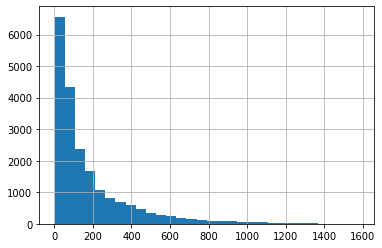

In [22]:
#изучем столбeц days_exposition
data['days_exposition'].hist(bins=30); # построим гистограмму 

Видим, что очень много значений равных 0 и основная часть до 200 дней.

In [23]:
data['days_exposition'].value_counts()

45.0      880
60.0      538
7.0       234
30.0      208
90.0      204
         ... 
969.0       1
1.0         1
1147.0      1
1148.0      1
1174.0      1
Name: days_exposition, Length: 1141, dtype: int64

Разброс достаточно большой, много не заполненных строк (3181). Пока оставим все как есть.

In [24]:
# посмотрим теперь на данные по этажности домов (floors_total)
data['floors_total'].describe()

count    23602.000000
mean        10.673079
std          6.595575
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

Стандартное отклонение 6,6 - достаточно большое, минимально 1 этаж, что логично, максимально 60, что тоже реально. 

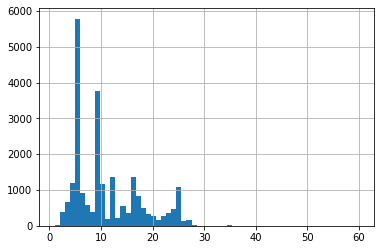

In [25]:
#построим гистограмму
data['floors_total'].hist(bins=60);

Оставим данные пропуски, на наш анализ они не должны особо повлиять.

In [26]:
#посмотрим сколько пропущенных значений у нас осталось
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total               86
living_area              1903
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area             2276
balcony                     0
locality_name               0
airports_nearest         5540
cityCenters_nearest      5517
parks_around3000         5516
parks_nearest           15614
ponds_around3000         5516
ponds_nearest           14584
days_exposition          3181
dtype: int64

Удивляет то, что достаточно много пропусков данных в столбцах, которые заполняются автоматически (airports_nearest, cityCenters_nearest, parks_around3000, parks_nearest, ponds_around3000, ponds_nearest). Это может быть связано с неполнотой данных переданных нам или ошибкой при выгрузке. Приэтом, мы не сможем сами дозаполнить данную информацию.
Еще очень удивляет отсутствие данных в living_area, т.к. это один из важных параметров недвижимости. Пока так же не будем трогать данный столбец.
Тип данных столбцов parks_around3000 и ponds_around3000 невозможно поменять на более явный для них тип - целое, число, т.к. в данных столбцах содержатся пропуски, которые мы никак не можем заполнить.

In [27]:
# теперь разбиремся с дубликатами
#найдем явные дубликаты
data.duplicated().sum()

0

Явных дубликатов нет. Посмотрим, что с неявными.

In [28]:
#проанализируем уникальные значения locality_name
sorted_data = data['locality_name'].sort_values()
sorted_data.unique()


array(['Бокситогорск', 'Волосово', 'Волхов', 'Всеволожск', 'Выборг',
       'Высоцк', 'Гатчина', 'Зеленогорск', 'Ивангород', 'Каменногорск',
       'Кингисепп', 'Кириши', 'Кировск', 'Колпино', 'Коммунар',
       'Красное Село', 'Кронштадт', 'Кудрово', 'Лодейное Поле',
       'Ломоносов', 'Луга', 'Любань', 'Мурино', 'Никольское',
       'Новая Ладога', 'Отрадное', 'Павловск', 'Петергоф', 'Пикалёво',
       'Подпорожье', 'Приморск', 'Приозерск', 'Пушкин', 'Санкт-Петербург',
       'Светогорск', 'Сертолово', 'Сестрорецк', 'Сланцы', 'Сосновый Бор',
       'Сясьстрой', 'Тихвин', 'Тосно', 'Шлиссельбург',
       'городской поселок Большая Ижора', 'городской поселок Янино-1',
       'городской посёлок Будогощь', 'городской посёлок Виллози',
       'городской посёлок Лесогорский', 'городской посёлок Мга',
       'городской посёлок Назия', 'городской посёлок Новоселье',
       'городской посёлок Павлово', 'городской посёлок Рощино',
       'городской посёлок Свирьстрой', 'городской посёлок Совет

Видим, что встречается 'городской посёлок ...' и 'городской поселок ...'(можно изменить все поселки на посёлки), 'поселок Мурино' и 'Мурино','Кудрово' и 'деревня Кудрово', 'поселок Лесное' и 'коттеджный посёлок Лесное', 'поселок станции Вещево' и 'посёлок при железнодорожной станции Вещево', 'поселок станции Приветнинское' и 'посёлок при железнодорожной станции Приветнинское'.

In [29]:
#для начала переименуем поселок в посёлок
data['locality_name'] = data['locality_name'].str.replace('поселок', 'посёлок')

In [30]:
# теперь избавимся от остальных дубликатов
duplicated = ['посёлок Мурино','деревня Кудрово','посёлок Лесное', 'посёлок станции Вещево', 'посёлок станции Приветнинское'  ]
name = ['Мурино', 'Кудрово', 'коттеджный посёлок Лесное', 'посёлок при железнодорожной станции Вещево', 'посёлок при железнодорожной станции Приветнинское']
data['locality_name'] = data['locality_name'].replace(duplicated, name)
# проверим наши исправления
sorted_data = data['locality_name'].sort_values()
sorted_data.unique()

array(['Бокситогорск', 'Волосово', 'Волхов', 'Всеволожск', 'Выборг',
       'Высоцк', 'Гатчина', 'Зеленогорск', 'Ивангород', 'Каменногорск',
       'Кингисепп', 'Кириши', 'Кировск', 'Колпино', 'Коммунар',
       'Красное Село', 'Кронштадт', 'Кудрово', 'Лодейное Поле',
       'Ломоносов', 'Луга', 'Любань', 'Мурино', 'Никольское',
       'Новая Ладога', 'Отрадное', 'Павловск', 'Петергоф', 'Пикалёво',
       'Подпорожье', 'Приморск', 'Приозерск', 'Пушкин', 'Санкт-Петербург',
       'Светогорск', 'Сертолово', 'Сестрорецк', 'Сланцы', 'Сосновый Бор',
       'Сясьстрой', 'Тихвин', 'Тосно', 'Шлиссельбург',
       'городской посёлок Большая Ижора', 'городской посёлок Будогощь',
       'городской посёлок Виллози', 'городской посёлок Лесогорский',
       'городской посёлок Мга', 'городской посёлок Назия',
       'городской посёлок Новоселье', 'городской посёлок Павлово',
       'городской посёлок Рощино', 'городской посёлок Свирьстрой',
       'городской посёлок Советский', 'городской посёлок Фёд

In [31]:
data['last_price'] = data['last_price'].astype(int)

In [32]:
# еще раз посмотрим на наши данные
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23688 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23688 non-null  int64         
 1   last_price            23688 non-null  int64         
 2   total_area            23688 non-null  float64       
 3   first_day_exposition  23688 non-null  datetime64[ns]
 4   rooms                 23688 non-null  int64         
 5   ceiling_height        23688 non-null  float64       
 6   floors_total          23602 non-null  float64       
 7   living_area           21785 non-null  float64       
 8   floor                 23688 non-null  int64         
 9   is_apartment          23688 non-null  bool          
 10  studio                23688 non-null  bool          
 11  open_plan             23688 non-null  bool          
 12  kitchen_area          21412 non-null  float64       
 13  balcony         

In [33]:
# посчитаем сколькопроцентов данных мы удалили в процессе предобработки
23688/23699

0.9995358453943204

Мы удалили менее 1 % данных. На наш анализ это не должно повлиять.

### Посчитайте и добавьте в таблицу новые столбцы

In [34]:
# создадим столбец 'price_per_square_meter', в который поместим данные о цене за один квадратный метр, округлим до целых
data['price_per_square_meter'] = round(data['last_price']/data['total_area'], 0)

In [35]:
#добавим столбец с днями недели, в которые были опубликованы объявления
data['weekday'] = data['first_day_exposition'].dt.weekday
#добавим столбец с месяцем, в которые были опубликованы объявления
data['month'] = data['first_day_exposition'].dt.month
#добавим столбец с годами, в которые были опубликованы объявления
data['year'] = data['first_day_exposition'].dt.year

In [36]:
# добавим столбец 'floor_type', в котором укажем тип этажа квартиры (значения — «первый», «последний», «другой»)
data['floor_type'] = np.where(data['floor']==1,'первый' , 'другой') 
data['floor_type'] = np.where(data['floor']==data['floors_total'],'последний', data['floor_type'])


In [37]:
# создадим столбец, с данными по расстоянию до центра города в километрах. 
#Т.к. у нас столбец 'cityCenters_nearest' в метрах, то нужно будет перевести в км.и округлим до десятых
data['cityCenters_nearest_km'] = round(data['cityCenters_nearest']/1000, 1)

#проверим добавленные столбцы и данные в них
pd.options.display.max_columns=28
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_square_meter,weekday,month,year,floor_type,cityCenters_nearest_km
0,20,13000000,108.0,2019-03-07,3,2.70,16.0,51.0,8,False,False,False,25.0,0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN,120370.0,3,3,2019,другой,16.0
1,7,3350000,40.4,2018-12-04,1,2.73,11.0,18.6,1,False,False,False,11.0,2,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,82921.0,1,12,2018,первый,18.6
2,10,5196000,56.0,2015-08-20,2,2.73,5.0,34.3,4,False,False,False,8.3,0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,92786.0,3,8,2015,другой,13.9
3,0,64900000,159.0,2015-07-24,3,2.73,14.0,NaN,9,False,False,False,NaN,0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0,408176.0,4,7,2015,другой,6.8
4,2,10000000,100.0,2018-06-19,2,3.03,14.0,32.0,13,False,False,False,41.0,0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,100000.0,1,6,2018,другой,8.1


### Проведите исследовательский анализ данных

count    23688.000000
mean        60.349328
std         35.650707
min         12.000000
25%         40.000000
50%         52.000000
75%         69.900000
max        900.000000
Name: total_area, dtype: float64

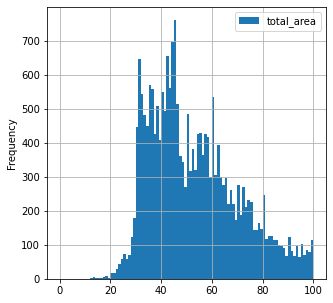

In [38]:
# изучим общую площадь квартир 
data.plot(y='total_area', kind='hist', figsize=(5, 5), grid=True, range=(0, 100), bins=100);
data['total_area'].describe()

Видим, что большая часть квартир площадью до 70 кв.метров, при этом минимальная площадь 12 кв.метров (может быть это комната в коммуналке), а максимальная 900 кв.метров. Средняя площадь 60,3 кв.метра и медианная площадь 52 кв.метра вполне соответствуют действительности, выбросы (12 и 900 кв.метров) особо не повлияли на данные.
На графике видно, что основная часть квартир площадью от 40 до 50 кв.метра, чуть меньше от 30 до 40 кв.метра, далее от 50 до 60 кв.метра. 

count    21785.000000
mean        34.457312
std         22.020939
min          2.000000
25%         18.600000
50%         30.000000
75%         42.300000
max        409.700000
Name: living_area, dtype: float64

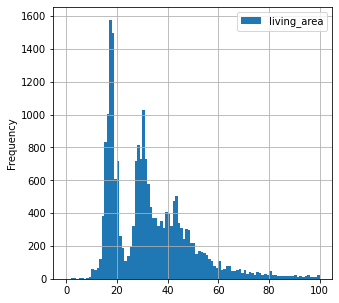

In [39]:
# теперь рассмотрим жилую площадь
data.plot(y='living_area', kind='hist', figsize=(5, 5), grid=True, range=(0, 100), bins=100)
data['living_area'].describe()

Здесь так же видны выбросы: 409,7 кв.метров (максимальная площадь) и 2 кв.метра (минимальное значение), но это вполне реальный показатель исходя из того, что у нас максимальная общая площадь 900 кв.метров и минимальная 12 кв.метра. Так же как и при анализе общей плащади, здесь достаточно реальные показатели: средняя площадь - 34,5 кв.метра, медианная - 30 кв.метров.
На графике можно отметить, что чаще всего встречающаяся жилая площадь анализируемых квартир от 10 до 20 квадратных метров (что соизмеримо с самыми популярными,согласно нашим данным, площадями квартир от 40 до 50 кв.метров), далее жилая площать от 30 до 40 кв.метров.

count    21412.000000
mean        10.570381
std          5.906346
min          1.300000
25%          7.000000
50%          9.100000
75%         12.000000
max        112.000000
Name: kitchen_area, dtype: float64

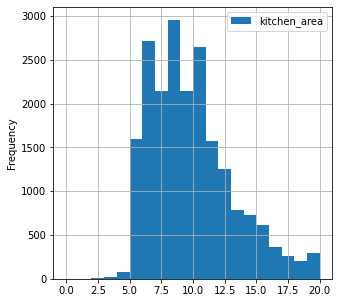

In [40]:
# рассмотрим площадь кухни
data.plot(y='kitchen_area', kind='hist', figsize=(5, 5), grid=True, range=(0, 20), bins=20)
data['kitchen_area'].describe()

И снова повторяются выбросы, которые мы наблюдали в предыдущих исследованиях (что логично): 112 кв.метров (максимальная площадь) и 1,3 кв.метра (минимальное значение). 
Здесь так же все в порядке с показателями, которые отражают существующую реальность:среднеарифметическая - 10,6 кв.метра, медианная - 9,1 кв.метр.
На графике видно, что в основном кухни в квартирах от 7,6 до 10 метров, чуть меньше от 6 до 7,5 метров и от 10 до 12 метров. 

count     23688.000000
mean       6537.219872
std       10864.734577
min          12.190000
25%        3400.000000
50%        4650.000000
75%        6800.000000
max      763000.000000
Name: last_price_in_tousends, dtype: float64

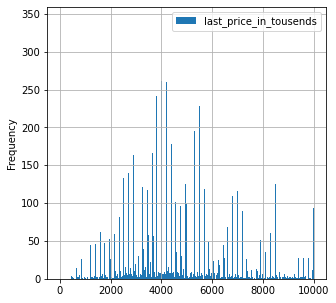

In [41]:
#рассмотрим данные о цене объекта
#для удобства переведем их в тыс.руб.
data['last_price_in_tousends'] = data['last_price']/1000
data.plot(y='last_price_in_tousends',bins = 1000, kind='hist', figsize=(5, 5), grid=True, range=(0, 10000))
data['last_price_in_tousends'].describe()

Средняя стоимость вполне реальна для Санкт-Петербурга - 6,5 млн.руб., чуть меньше медианная - 4,7 млн.руб. Данные вполне реальные. Но опять мы видим вбросы: очень странная минимальная цена  - 12,2 тыс.руб. (даже за комнату 12 кв.метров как-то очень мало) и вполне закономерная максимальная цена 763 млн.руб.
Из графика видно, что пик по количеству проданный квартир приходится на стоимость 4 млн.руб.

In [42]:
# рассмотрим самые дорогие квартиры/дома и самые дешевые, на них ли приходится вбросы по максимальной и минималоьной площади
pd.options.display.max_columns=50
data.query('last_price_in_tousends>200000').sort_values(by='last_price_in_tousends', ascending=False)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_square_meter,weekday,month,year,floor_type,cityCenters_nearest_km,last_price_in_tousends
12971,19,763000000,400.0,2017-09-30,7,2.73,10.0,250.0,10,False,False,False,NaN,2,Санкт-Петербург,25108.0,3956.0,1.0,530.0,3.0,756.0,33.0,1907500.0,5,9,2017,последний,4.0,763000.0
19540,8,420000000,900.0,2017-12-06,12,2.80,25.0,409.7,25,False,False,False,112.0,0,Санкт-Петербург,30706.0,7877.0,0.0,NaN,2.0,318.0,106.0,466667.0,2,12,2017,последний,7.9,420000.0
14706,15,401300000,401.0,2016-02-20,5,2.73,9.0,204.0,9,False,False,False,24.0,3,Санкт-Петербург,21912.0,2389.0,1.0,545.0,1.0,478.0,393.0,1000748.0,5,2,2016,последний,2.4,401300.0
1436,19,330000000,190.0,2018-04-04,3,3.50,7.0,95.0,5,False,False,False,40.0,0,Санкт-Петербург,23011.0,1197.0,3.0,519.0,3.0,285.0,233.0,1736842.0,2,4,2018,другой,1.2,330000.0
15651,20,300000000,618.0,2017-12-18,7,3.40,7.0,258.0,5,False,False,False,70.0,0,Санкт-Петербург,32440.0,5297.0,0.0,NaN,2.0,198.0,111.0,485437.0,0,12,2017,другой,5.3,300000.0
22831,18,289238400,187.5,2019-03-19,2,3.37,6.0,63.7,6,False,False,False,30.2,0,Санкт-Петербург,22494.0,1073.0,3.0,386.0,3.0,188.0,NaN,1542605.0,1,3,2019,последний,1.1,289238.4
16461,17,245000000,285.7,2017-04-10,6,3.35,7.0,182.8,4,False,False,False,29.8,0,Санкт-Петербург,33143.0,6235.0,3.0,400.0,3.0,140.0,249.0,857543.0,0,4,2017,другой,6.2,245000.0
13749,7,240000000,410.0,2017-04-01,6,3.40,7.0,218.0,7,False,False,False,40.0,0,Санкт-Петербург,32440.0,5297.0,0.0,NaN,2.0,198.0,199.0,585366.0,5,4,2017,последний,5.3,240000.0
5893,3,230000000,500.0,2017-05-31,6,2.73,7.0,NaN,7,False,False,False,40.0,0,Санкт-Петербург,32440.0,5297.0,0.0,NaN,2.0,198.0,50.0,460000.0,2,5,2017,последний,5.3,230000.0


In [43]:
data.query('last_price_in_tousends<100').sort_values(by='last_price_in_tousends', ascending=False)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_square_meter,weekday,month,year,floor_type,cityCenters_nearest_km,last_price_in_tousends
8793,7,12190,109.0,2019-03-20,2,2.75,25.0,32.0,25,False,False,False,40.5,0,Санкт-Петербург,36421.0,9176.0,1.0,805.0,0.0,NaN,8.0,112.0,2,3,2019,последний,9.2,12.19


Оказалось, что самая дорогая квартира не самая большая из данной выборки. А вот по самой дешевой квартире выходит какая-то ошибка, т.к. площадь квартиры 109 кв.метров (жилая -32 кв.метра, кухня - 40,5 кв.метра) и она расположена в Санкт-Петербурге в 9 км от центра. Скорей всего в данные закралась ошибка и для дальнейшего анализа данный вброс следует удалить.

In [44]:
#удалим строку с ценой квартиры 12190 руб.
data = data.query('last_price!=12190')
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_square_meter,weekday,month,year,floor_type,cityCenters_nearest_km,last_price_in_tousends
0,20,13000000,108.0,2019-03-07,3,2.70,16.0,51.0,8,False,False,False,25.0,0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN,120370.0,3,3,2019,другой,16.0,13000.0
1,7,3350000,40.4,2018-12-04,1,2.73,11.0,18.6,1,False,False,False,11.0,2,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,82921.0,1,12,2018,первый,18.6,3350.0
2,10,5196000,56.0,2015-08-20,2,2.73,5.0,34.3,4,False,False,False,8.3,0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,92786.0,3,8,2015,другой,13.9,5196.0
3,0,64900000,159.0,2015-07-24,3,2.73,14.0,NaN,9,False,False,False,NaN,0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0,408176.0,4,7,2015,другой,6.8,64900.0
4,2,10000000,100.0,2018-06-19,2,3.03,14.0,32.0,13,False,False,False,41.0,0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,100000.0,1,6,2018,другой,8.1,10000.0


In [45]:
# снова посмотрим на данные по квартирам
data['last_price_in_tousends'].describe()

count     23687.000000
mean       6537.495341
std       10864.881199
min         430.000000
25%        3400.000000
50%        4650.000000
75%        6800.000000
max      763000.000000
Name: last_price_in_tousends, dtype: float64

Средняя и медианная стоимости не изменились, но зато минимальная стала более реальной 430 тыс.руб.

count    23687.000000
mean         2.070756
std          1.078476
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64

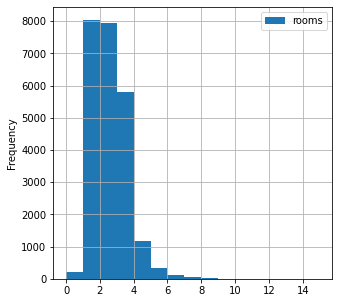

In [46]:
#рассмотрим данные по количеству комнат
data.plot(y='rooms', kind='hist', figsize=(5, 5), grid=True, range=(0, 15), bins=15)
data['rooms'].describe()

Все ожидаемо:среднее и медианное - 2. Максимально 19 комнат, а вот минимальное 0. Надо проверить данные. На графике видно, что основная часть квартир с 1, 2-мя или 3-мя комнатами, в половину меньше с 4-мя, 5-ю и 6-ю, совсем не значительное количество после 7-ми комнат.

In [47]:
data.query('rooms==0')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_square_meter,weekday,month,year,floor_type,cityCenters_nearest_km,last_price_in_tousends
144,1,2450000,27.00,2017-03-30,0,2.73,24.0,15.50,2,False,True,False,NaN,2,Мурино,NaN,NaN,NaN,NaN,NaN,NaN,181.0,90741.0,3,3,2017,другой,NaN,2450.0
349,4,2320000,25.00,2017-09-27,0,2.73,14.0,17.00,1,False,False,True,NaN,0,Кудрово,NaN,NaN,NaN,NaN,NaN,NaN,45.0,92800.0,2,9,2017,первый,NaN,2320.0
440,8,2480000,27.11,2018-03-12,0,2.73,17.0,24.75,4,False,True,False,NaN,2,Санкт-Петербург,38171.0,15015.0,0.0,NaN,2.0,982.0,64.0,91479.0,0,3,2018,другой,15.0,2480.0
508,0,3375000,34.40,2017-03-28,0,2.73,26.0,24.30,19,False,False,True,NaN,1,посёлок Парголово,53115.0,19292.0,0.0,NaN,1.0,593.0,430.0,98110.0,1,3,2017,другой,19.3,3375.0
608,2,1850000,25.00,2019-02-20,0,2.73,10.0,NaN,7,False,True,False,NaN,0,посёлок Шушары,NaN,NaN,NaN,NaN,NaN,NaN,29.0,74000.0,2,2,2019,другой,NaN,1850.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23210,7,3200000,26.00,2017-09-01,0,2.73,25.0,18.00,16,False,True,False,NaN,0,Санкт-Петербург,11405.0,13222.0,0.0,NaN,1.0,623.0,14.0,123077.0,4,9,2017,другой,13.2,3200.0
23442,0,2500000,27.70,2017-09-28,0,2.73,24.0,18.00,4,False,False,True,NaN,2,Мурино,NaN,NaN,NaN,NaN,NaN,NaN,4.0,90253.0,3,9,2017,другой,NaN,2500.0
23554,15,3350000,26.00,2018-09-07,0,2.73,19.0,NaN,8,False,True,False,NaN,0,Санкт-Петербург,18090.0,17092.0,0.0,NaN,2.0,112.0,31.0,128846.0,4,9,2018,другой,17.1,3350.0
23592,10,1450000,29.00,2017-11-11,0,2.73,9.0,18.00,8,False,False,True,NaN,2,Никольское,NaN,NaN,NaN,NaN,NaN,NaN,82.0,50000.0,5,11,2017,другой,NaN,1450.0


Так как у нас всего 197 квартир с 0 комнат, а это меньше 1% от наших данных, то пока не будем обращать на них внимание. В остальном данные близки к реальным.

count    23687.000000
mean         2.727809
std          0.216956
min          2.000000
25%          2.600000
50%          2.730000
75%          2.730000
max          5.800000
Name: ceiling_height, dtype: float64

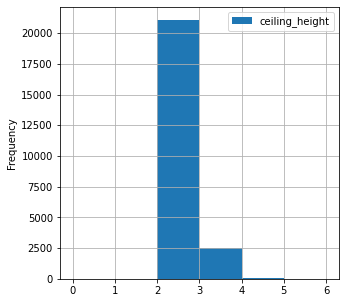

In [48]:
#расмотрим высоту потолков с уже заполненными пропусками и проработанными аномалиями
data.plot(y='ceiling_height', kind='hist', figsize=(5, 5), grid=True, range=(0, 6), bins=6)
data['ceiling_height'].describe()

Средняя и медианная высота потолков 2,7 метра, максимальная 5,8 метров, минимальная 2,0 метра. Данные хорошие и более похожи на правду, чем первоначальные. По графику видно, что основная масса квартир с высотой потолков от 2,5 до 3,0 метров. 

count    23687.000000
mean         5.891586
std          4.883908
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max         33.000000
Name: floor, dtype: float64

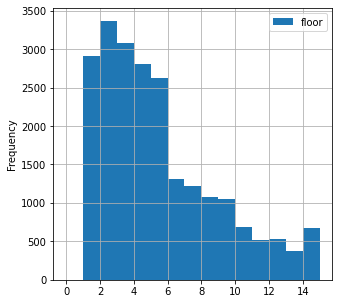

In [49]:
# проанализируем этаж, на котором находится данная недвижимость
data.plot(y='floor', kind='hist', figsize=(5, 5), grid=True, range=(0, 15), bins=15)
data['floor'].describe()

Среднее значение этажа 5,9, медианное значение 4, минимальный этаж - 1, максимальный - 33. Из данных графика видно, что больше всего квартир на 2 этаже, далее идет 3 этаж, чуть меньше на 1-м и на 4-м.

In [50]:
# проанализируем типы этажей, на которых распологаются квартиры
data_floor_type = data['floor_type'].value_counts().sort_values(ascending=False)
data_floor_type

другой       17439
последний     3358
первый        2890
Name: floor_type, dtype: int64

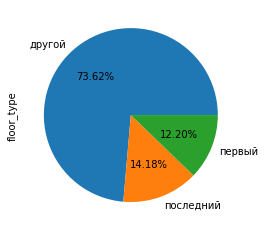

In [51]:
data_floor_type.plot(y='floor_type', kind='pie', autopct='%1.2f%%');

В основном квартиры располагаются не на первом и не на последнем этажах. Количество квартир, расположенных на первых на последних этажах близки по значению (квартир на первых на 2% (от общего) меньше  чем на последних этажах). На круговой диаграмме все это очень хорошо видно.

count    23601.000000
mean        10.672472
std          6.595055
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

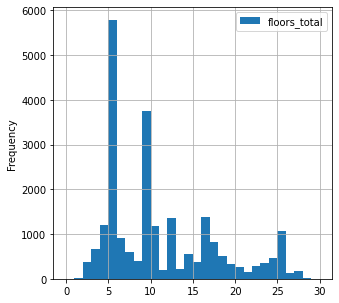

In [52]:
# проанализируем общее количество этажей в домах
data.plot(y='floors_total', kind='hist', figsize=(5, 5), grid=True, range=(0, 30), bins=30)
data['floors_total'].describe()

Из графика видно, что чаще выставлены на продажу квартиры в домах 6 этажных, на втором месте по популярности 9-10 этажные дома и совсем мало в домах выше 27 этажей.

count    18170.000000
mean     14191.761145
std       8609.500612
min        181.000000
25%       9238.000000
50%      13100.000000
75%      16293.000000
max      65968.000000
Name: cityCenters_nearest, dtype: float64

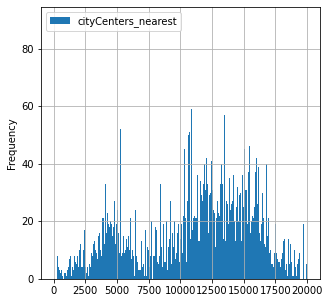

In [86]:
# проанализируем расстояние до центра города
data.plot(y='cityCenters_nearest', kind='hist', figsize=(5, 5), grid=True, range=(0, 20000), bins=1000)
                                                                                    
data['cityCenters_nearest'].describe()

Из данных видно, что среднее и медианные значения удаленности от цента города очень близки по значению (14192 и 13100 м. соответственно), минимальное удаление 181 м (квартиры расположены в самом центре), а максимальное 65968 м. Но при этом большая часть анализируемой недвижимости находится на растоянии от 12000 до 1300 м и от 14000 до 15000 м.

count    18147.000000
mean     28794.570452
std      12632.721422
min          0.000000
25%      18583.500000
50%      26726.000000
75%      37280.500000
max      84869.000000
Name: airports_nearest, dtype: float64

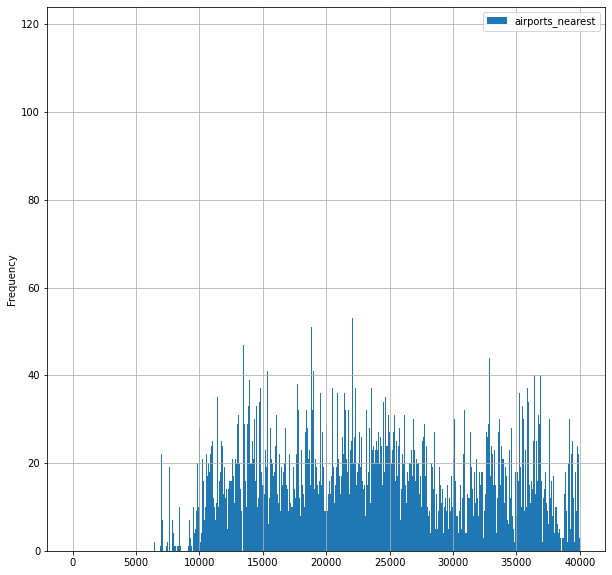

In [54]:
# проанализируем расстояние до аэропорта
data.plot(y='airports_nearest', kind='hist', figsize=(10, 10), grid=True, range=(0, 40000), bins = 1000)
data['airports_nearest'].describe()

Среднее растояние до аэропортов составляет 28,8 км., медианное 26,7 км., минимальное значение 0 (недвижимость у аэропорта), максимальное 84,9 км. На графике видно, что большинство квартир находятся на расстоянии около 22,5 км, чуть меньше - около 18 км. 

count    8073.000000
mean      490.801685
std       342.397058
min         1.000000
25%       288.000000
50%       455.000000
75%       612.000000
max      3190.000000
Name: parks_nearest, dtype: float64

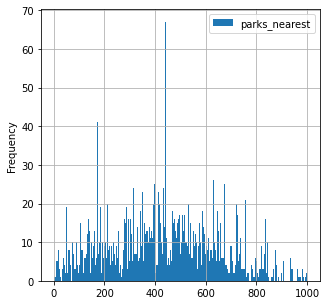

In [84]:
# проанализируем расстояние до парка
data.plot(y='parks_nearest', kind='hist', figsize=(5, 5), grid=True, range=(0, 1000), bins=1000)
data['parks_nearest'].describe()

Большинство недвижимости находится достаточно близко к паркам (минимальное значение 1 метр), в среднем на расстоянии около 500 метров, максимально в 3,2 км., но надо учитывать, что у нас всего 8073 строки с данными из 23699. 
На графике видно, что самое большое количество квартир находится на расстоянии приблизительно 450 метров.

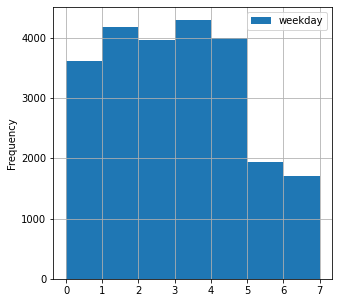

In [56]:
# проанализируем дни недели, в которые были размещены объявления о пражаде квартир
data.plot(y='weekday', kind='hist', figsize=(5, 5), grid=True, range=(0, 7), bins=7);

Из графика видно, самыми популярными днями для размещения объявлений были вторник и четверг, далее пятница, а вот в выходные объявления размещали в 2 раза реже.

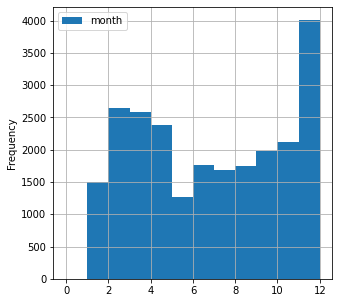

In [57]:
# проанализируем месяцы, в которые были размещены объявления о пражаде квартир
data.plot(y='month', kind='hist', figsize=(5, 5), grid=True, range=(0, 12), bins=12);

Из графика видно, что чаще объявения размещают в декабре, потом в феврале и марте, а меньше всего в январе.

Изучим как быстро продавались квартиры, точнее как долго объявление находилось на сервисе Яндекс.Недвижимость

count    20506.000000
mean       180.889593
std        219.756008
min          1.000000
25%         45.000000
50%         95.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64

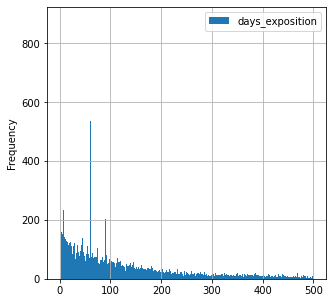

In [90]:
data.plot(y='days_exposition', kind='hist', figsize=(5, 5), grid=True, range=(0, 500), bins=500)
data['days_exposition'].describe()

Из полученных данных видим, что минимальный срок продажи 1 день, что просто отлично, а вот средняя продолжительность уже 180 дней (полгода), при этом медианное значение 95 дней, а значит половина всех квартир была продана менее чем за 3 месяца, что достаточно хорошо, но есть и максимум - 1580 дней (более 4 лет). 

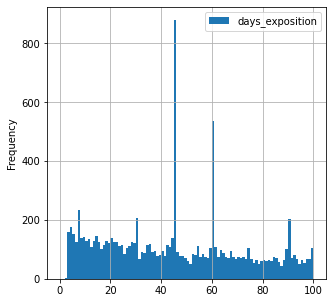

In [59]:
#поподробнее изучим период до 100 дней
data.plot(y='days_exposition', kind='hist', figsize=(5, 5), grid=True, range=(0, 100), bins=100);

Теперь мы видим пики приблизительно на 45 день и 60 день, в которые продажи растут от 2,5 до 3 раз (это выброс?)! Если не принимать их во внимание то максимальное количество продаж приходится на конец первой недели, что достаточно быстро.

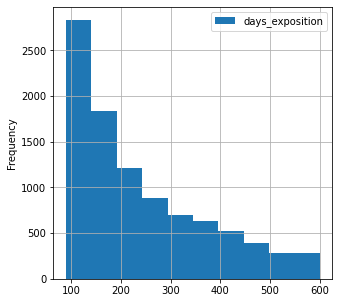

In [60]:
#рассмотрим как распределились продажи, которые пробыли на сайте более 100 дней
data.plot(y='days_exposition', kind='hist', figsize=(5, 5), grid=True, range=(90, 600), bins=10);

Видим, что приблизительно с 140 дня продажи постепенно снижаются.
Подведя итог можно сказать, что половина всех квартир продаются за первые 3 месяца (это хороший показатель), большая же часть квартир продается уже к 232 дню (третий квартиль), остальные квартиры продаются достаточно долго.

In [61]:
# разбирем какие факторы больше всего влияют на общую (полную) стоимость объекта
# рассотрим влияние общей площади на цену
dependence_of_price_on_total_area = data.pivot_table(index='total_area', values='last_price', 
                                                     aggfunc=['mean', 'median', 'count'])

In [62]:
# переименуем столбцы, чтобы избавится от двойной записи
dependence_of_price_on_total_area.columns = ['mean_price', 'median_price', 'count'] 
dependence_of_price_on_total_area

,mean_price,median_price,count
total_area,,,
12.0,2400000.0,2400000.0,1
13.0,2350000.0,1850000.0,3
13.2,1686000.0,1686000.0,1
14.0,1190000.0,1190000.0,1
15.0,1725000.0,1725000.0,2
...,...,...,...
590.0,65000000.0,65000000.0,1
618.0,300000000.0,300000000.0,1
631.0,140000000.0,140000000.0,1


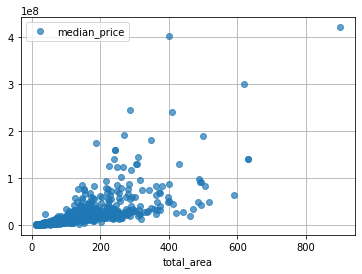

In [63]:
# построим график
dependence_of_price_on_total_area.plot(y='median_price', style='o', alpha=0.7, grid=True);

На графике видна зависимость.

In [64]:
# посчитаем коэффициент корреляции Пирсона
corr_price_total_area = data['total_area'].corr(data['last_price'])
corr_price_total_area 

0.6538833181068494

Коэффициент Пирсона равен 0,65 это заметная корреляция. Следовательно, цена зависит от общей площади. 

In [65]:
# посмотрим на зависимость цены от жилой площади
dependence_of_price_on_living_area = data.pivot_table(index='living_area', values='last_price', 
                                                     aggfunc=['mean', 'median', 'count'])

In [66]:
# переименуем столбцы, чтобы избавится от двойной записи
dependence_of_price_on_living_area.columns = ['mean_price', 'median_price', 'count'] 
dependence_of_price_on_living_area

,mean_price,median_price,count
living_area,,,
2.0,4340000.0,4340000.0,2
3.0,34715000.0,34715000.0,2
5.0,2680000.0,2680000.0,1
5.4,6100000.0,6100000.0,1
6.0,3799000.0,3799000.0,1
...,...,...,...
322.3,140000000.0,140000000.0,1
332.0,50000000.0,50000000.0,1
347.5,91500000.0,91500000.0,1


0.5658531520525434

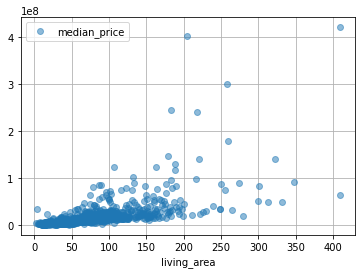

In [67]:
# построим график и посчитаем коэффициент корреляции Пирсона
dependence_of_price_on_living_area.plot(y='median_price', style='o', alpha=0.5, grid=True)
corr_price_living_area = data['living_area'].corr(data['last_price'])
corr_price_living_area 

Видим, что коэффициент Пирсона ниже чем корреляция цены и общей площади и он равен 0,57. По графику так же видна определенная зависимость, но есть и выбивающиеся показатели.

In [68]:
#рассмотрим влияние площади кухни на цену квартиры
dependence_of_price_on_kitchen_area = data.pivot_table(index='kitchen_area', values='last_price', 
                                                     aggfunc=['mean', 'median', 'count'])
# переименуем столбцы, чтобы избавится от двойной записи
dependence_of_price_on_kitchen_area.columns = ['mean_price', 'median_price', 'count'] 
dependence_of_price_on_kitchen_area

,mean_price,median_price,count
kitchen_area,,,
1.30,4.250000e+06,4250000.0,1
2.00,2.821429e+06,2720000.0,7
2.30,2.940000e+06,2940000.0,1
2.40,2.200000e+06,2200000.0,1
2.89,5.967734e+06,5967734.0,1
...,...,...,...
93.20,8.240000e+07,82400000.0,1
100.00,6.500000e+07,65000000.0,1
100.70,1.250000e+07,12500000.0,1


0.521513595078376

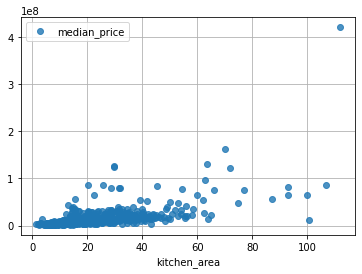

In [69]:
# построим график и посчитаем коэффициент корреляции Пирсона
dependence_of_price_on_kitchen_area.plot(y='median_price', style='o', alpha=0.8, grid=True)
corr_price_kitchen_area = data['kitchen_area'].corr(data['last_price'])
corr_price_kitchen_area 

Коэффициент корреляции еще ниже, чем при зависимости цены от жилой площади. Проанаизировав 3 показателя площади, можно сделать вывод, что зависимость цены от площадей есть, но более значимая от общей площади, чем от площади кухни или жилой.

In [70]:
# теперь рассмотрим зависимость цены от количества комнат
dependence_of_price_on_rooms = data.pivot_table(index='rooms', values='last_price', 
                                                     aggfunc=['mean', 'median', 'count'])
dependence_of_price_on_rooms.columns = ['mean_price', 'median_price', 'count'] 
dependence_of_price_on_rooms

,mean_price,median_price,count
rooms,,,
0,3.337724e+06,2700000,197
1,3.833835e+06,3600000,8042
2,5.592801e+06,4770000,7935
3,8.179562e+06,6200000,5813
4,1.333395e+07,9000000,1179
5,2.376208e+07,14000000,326
6,3.170975e+07,19000000,105
7,5.147007e+07,24900000,59
8,5.022417e+07,23095000,12


0.3634565057449706

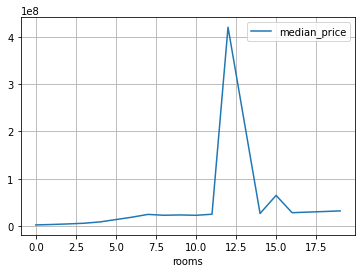

In [71]:
# построим график и посчитаем коэффициент корреляции Пирсона
dependence_of_price_on_rooms.plot(y='median_price', grid=True)
corr_price_rooms = data['rooms'].corr(data['last_price'])
corr_price_rooms 

Коэффициент корреляции Пирсона 0,36, что означает, что корреляция слабая. И то же мы видим на графике, хотя здесь мы видим резкий скачок цены квартиры за 12 комнат, в остальном зависимость не особо прослеживается. Можно сделать вывод, что количество комнат незначительно, но влияет на стоимость.

In [72]:
# рассмотрим зависимость цены от типа этажа, но котором расположена квартира
dependence_of_price_on_floor_type = data.pivot_table(index='floor_type', values='last_price', 
                                                     aggfunc=['mean', 'median', 'count'])
dependence_of_price_on_floor_type.columns = ['mean_price', 'median_price', 'count'] 
dependence_of_price_on_floor_type

,mean_price,median_price,count
floor_type,,,
другой,6.676209e+06,4850000,17439
первый,4.821862e+06,3900000,2890
последний,7.293649e+06,4300000,3358


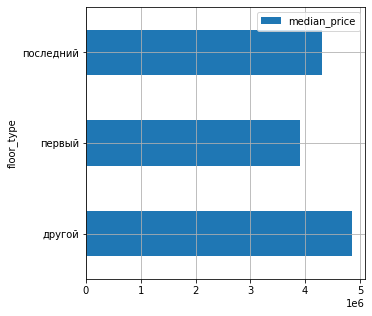

In [73]:
# построим график 
dependence_of_price_on_floor_type.plot(y='median_price', kind='barh', figsize=(5, 5), grid=True);

На графике видно, что квартиры на первом этаже стоят дешевле, чем квартиры на последнем, при этом квартиры на других этажах более дорогие.

In [74]:
#посмотрим как повлиял день недели размещения объявления на окончатильную цену
dependence_of_price_on_weekday = data.pivot_table(index='weekday', values='last_price', 
                                                     aggfunc=['mean', 'median', 'count'])
dependence_of_price_on_weekday.columns = ['mean_price', 'median_price', 'count'] 
dependence_of_price_on_weekday

,mean_price,median_price,count
weekday,,,
0,6.481841e+06,4650000,3610
1,6.395032e+06,4730000,4181
2,6.627933e+06,4700000,3970
3,6.708663e+06,4650000,4295
4,6.373761e+06,4580000,3997
5,6.977671e+06,4550000,1935
6,6.246180e+06,4550000,1699


0.002170071700707453

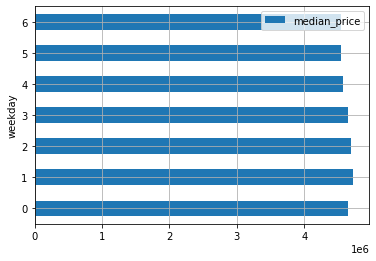

In [75]:
# построим график и посчитаем коэффициент корреляции Пирсона
dependence_of_price_on_weekday.plot(y='median_price', kind='barh', grid=True)
corr_price_weekday = data['weekday'].corr(data['last_price'])
corr_price_weekday

Коэффициент корреляции Пирсона 0,002 и можно сказать, что зависимости нет что и видно на графике. Изучив данные графика, можно сделать вывод, что самая высокая цена у объявлений, размещенных во вторник и чуть ниже - в среду.

In [76]:
# проанализируем зависимость от месяца размещения объявления
dependence_of_price_on_month = data.pivot_table(index='month', values='last_price', 
                                                     aggfunc=['mean', 'median', 'count'])
dependence_of_price_on_month.columns = ['mean_price', 'median_price', 'count'] 
dependence_of_price_on_month

,mean_price,median_price,count
month,,,
1,6.668233e+06,4600000,1500
2,6.468500e+06,4650000,2640
3,6.363649e+06,4650000,2585
4,6.737198e+06,4800000,2379
5,6.601221e+06,4500000,1273
6,6.310815e+06,4400000,1759
7,6.578043e+06,4650000,1693
8,6.353419e+06,4570000,1742
9,6.826241e+06,4700000,1980


0.0026899074239071273

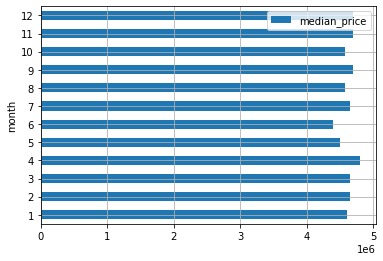

In [77]:
# построим график и посчитаем коэффициент корреляции Пирсона
dependence_of_price_on_month.plot(y='median_price', kind='barh', grid=True)
corr_price_month = data['month'].corr(data['last_price'])
corr_price_month

Здесь так же нет зависимости (коэффициент корреляции Пирсона 0,003). На графике же видно, что объявления с самой высокой медианной ценой на квартиры чаще размещали в апреле, а с самой низкой - в июне.

In [78]:
# посмотрим есть ли зависимость от года размещения объявлений
dependence_of_price_on_year = data.pivot_table(index='year', values='last_price', 
                                                     aggfunc=['mean', 'median', 'count'])
dependence_of_price_on_year.columns = ['mean_price', 'median_price', 'count'] 
dependence_of_price_on_year

,mean_price,median_price,count
year,,,
2014,1.208714e+07,7700000,137
2015,8.575542e+06,5350000,1190
2016,6.828354e+06,4550000,2782
2017,6.573079e+06,4500000,8186
2018,5.950509e+06,4550000,8514
2019,6.784741e+06,5050000,2878


-0.043033835257813964

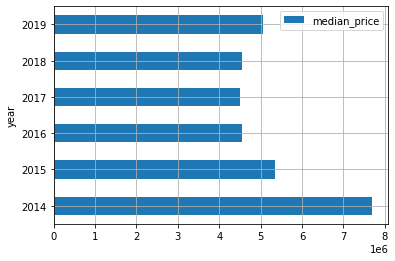

In [79]:
# построим график и посчитаем коэффициент корреляции Пирсона
dependence_of_price_on_year.plot(y='median_price', kind='barh', grid=True)
corr_price_year = data['year'].corr(data['last_price'])
corr_price_year

Коэффициент отрицательный, но при этом достаточно маленький -0,04, поэтому можно сказать, что зависимости от года размещения объявлений нет. На графике мы видим, медианная цена за 2014 год выше чем в остальные годы. 

Подведя итог, можно скзать, что в основном окончательная цена квартиры зависит от ее общей площади.

In [80]:
# посчитаем среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений 
# создадим сводную таблицу по наименованию населенного пункта и средней стоимости квадратного метра
big_locality = data.pivot_table(index='locality_name', values='price_per_square_meter', aggfunc=['mean','count'])
big_locality.columns = ['mean', 'count']
big_locality['mean'] = round(big_locality['mean'], 0) # округлим до целых значений
# сохраним в переменную 10 населённыч пункта с самой высокой средней стоимостью квадратного метра
big_locality_10 = big_locality.sort_values(by ='count', ascending=False).head(10)
big_locality_10 = big_locality_10.sort_values(by ='mean', ascending=False) # отсортируем по убыванию самой высокой средней цены
big_locality_10

,mean,count
locality_name,,
Санкт-Петербург,114796.0,15712
Пушкин,103126.0,369
Кудрово,95325.0,472
посёлок Парголово,90176.0,327
Мурино,86088.0,590
посёлок Шушары,78677.0,440
Колпино,75425.0,338
Гатчина,68746.0,307
Всеволожск,68654.0,398


Видим, что в среднем самая высокая стоимость квадратного метра в Санкт-Петербурге 114 796 руб., далее в городе Пушкин 103 126 рублей, а самая низкая средняя цена за квадратный метр в Выборге 58 142 руб. 

In [81]:
# выделим квартиры в Санкт-Петербурге и вычислим среднюю цену каждого километра отдаленности от центра города
# для начала избавимся от всех пропусков в столбце cityCenters_nearest_km
data['cityCenters_nearest_km'] = data['cityCenters_nearest_km'].fillna(111111111111).astype(int)
# создадим сводную таблицу в которую поместим только квартиры в Санкт-Петербурге
data_SPB = data.query('locality_name=="Санкт-Петербург" & cityCenters_nearest_km!=111111111111').pivot_table(index='cityCenters_nearest_km', values='last_price_in_tousends', aggfunc=['mean', 'count'])
data_SPB.columns = ['mean', 'count']
data_SPB['mean'] = data_SPB['mean'].astype(int)
data_SPB

,mean,count
cityCenters_nearest_km,,
0,24025,81
1,18974,236
2,16318,304
3,11899,511
4,14117,897
5,15059,752
6,15176,506
7,13006,389
8,8607,679


<AxesSubplot:xlabel='cityCenters_nearest_km'>

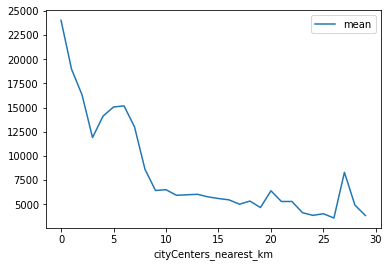

In [82]:
# построим график стоимости объектов при удалении от центра
data_SPB.plot(y='mean')

На графике видно, что чем ближе квартира к центру города, тем она дороже, но есть небольшое увеличение стоимости квартир удаленных на 5 км.от центра, это может быть связано, например,тем что с данные квартиры расположены в новом, более дорогом районе.

### Общий вывод

Проведя анализ данных по размещенным объявлениям по прадажам недвижимости в Санкт-Петербурге и Лененградской области, можно сказать, что:
* на окончательныю стоимость квартир влияет удаленность ее от центра города (чем ближе - тем дороже), а так же общая площадь квартиры (при этом есть более слабая зависимость стоимости от жилой площади и от площади кухни) и количества комнат.
* на стоимость не влияет день, месяц и год размещения объявлений, хотя чаще более дорогую недвижимость размещают по вторникам и в апреле. 
* тип этажа, на котором расположены квартиры так же не влияют на ее стоимость, но при этом в среднем дороже и чаще встречаются квартиры, расположенные не на первом и не на последнем этажах, а именно: больше всего квартир на 2 этаже, далее идет 3 этаж. Самый высокий этаж -30.
* основная часть квартир в датафрейме площадью до 70 кв.метров, при этом больше всего от 40 до 50 кв.метра, чуть меньше от 30 до 40 кв.метра, далее от 50 до 60 кв.метра, максимальная площадь 900 кв.м.
* в основном в объявлениях представлены квартиры 1-3-х комнатные, почти в 2 раза меньше квартир с 4-6 комнатами, но встречаются и с 19.
* среднеарифметическая стоимость квартир 6,5 млн.руб., что намного выше медианной, оторая составляет 4,7 млн.руб., приэтом максимальная стоимость 763 млн. руб.
* основная масса квартир с высотой потолков от 2,5 до 3,0 метров.
* минимальный срок продажи 1 день, что просто отлично, а вот средняя продолжительность уже 180 дней (полгода), при этом медианное значение 95 дней, а значит половина всех квартир была продана менее чем за 3 месяца, что достаточно хорошо, но есть и максимум - 1580 дней (более 4 лет).